In [13]:
%matplotlib inline

from torch.distributions.normal import Normal
import torch
from torch import tensor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from third_party.gmm_torch.gmm import GaussianMixture
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("whitegrid")

### Week 1, building an intuition with a toy version of the problem

Lets say we are explorers in a forest, and we want to find out where all of the wolf dens are. More specifically, we want to find out the probability of finding a wolf at any given point in the forest (so that we don't set farms on top of wolf populations)

We will model the probability of running into a wolf as a gaussian (normal distribution) around the wolf's den. Intuitively, the further you go from a den, the lower the chance of running into a wolf. 

As the forest has multiple wolf dens, we will model the overall distribution with a gaussian mixture model (GMM), which as its name implies, is just a combination of gaussians. 

Each gaussian has a mean (center) and variance (spread). Below we will define our forest, with 3 wolf dens centered at (1, 1), (-1, 1) and (0, -1), with variances of (0.1, 0.1), (0.1, 0.2), and (0.3, 0.1)

In [14]:
mu = torch.tensor(
    [[
        [1, 1],
        [-1, 1],
        [0, -1],
    ]]
)
var = torch.tensor(
    [[
        [0.1, 0.1],
        [0.1, 0.2],
        [0.3, 0.1],
    ]]
)

real_world = GaussianMixture(
    n_components=3,
    n_features=2,
    mu_init=mu,
    var_init=var,
    covariance_type="diag")

### This is what the real forest looks like, with the density of wolf sightings in blue. 

You can clearly see a gradient around the wolf dens. This probability distribution is what we want our explorers to learn. 

Lets say we are a genius explorer that knows about expectation maximization. We log the locations of all our wolf sightings and know how to fit a gaussian mixture model to that data. After seeing 50 wolves this is our model of the forst. Note that with just these sightings and the knowledge that our data is a 3-den gaussian mixture, this is the best possible estimate we could have. 

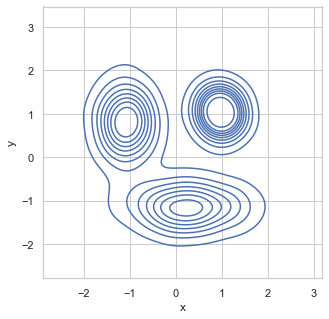

In [16]:
samples, classes = real_world.sample(50)

explorer = GaussianMixture(
    n_components=3,
    n_features=2,
    covariance_type="diag"
)

explorer.fit(samples)
visualize_gmm(explorer)

And here is what a group of explorers might learn given 5, 10, 50, 100, and 1000 wolf sightings. 

After 5 sightings our explorers have totally different ideas of where the wolf dens might be, however after 1000 sightings all of our explorers converge on a distribution very close to the true distribution. 

Estimates for 3 explorers trained with 5 samples.


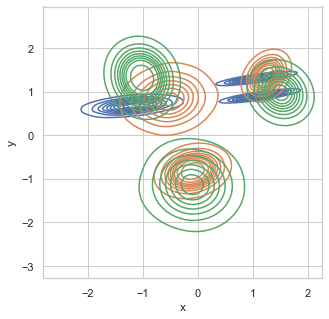

Estimates for 3 explorers trained with 10 samples.


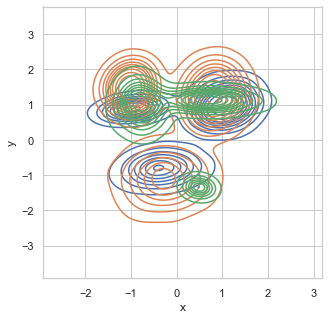

Estimates for 3 explorers trained with 50 samples.


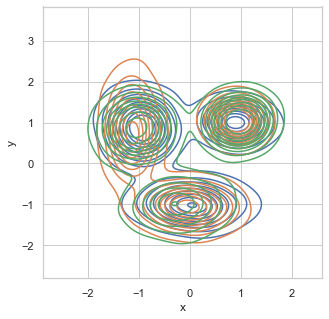

Estimates for 3 explorers trained with 100 samples.


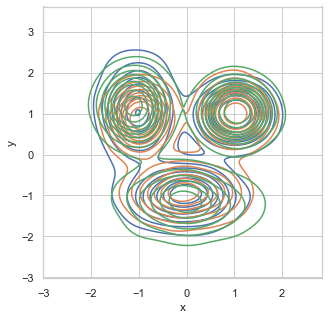

Estimates for 3 explorers trained with 1000 samples.


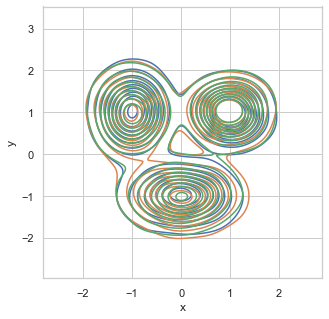

And finally, the real distribution


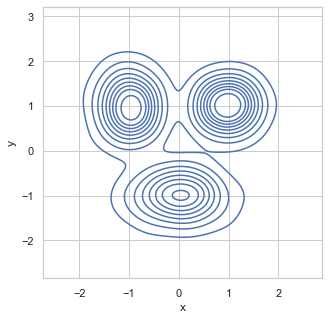

In [17]:
n_explorers = 3

for n_samples in [5, 10, 50, 100, 1000]:
    for _ in range(n_explorers):
        samples, classes = real_world.sample(n_samples)

        explorer = GaussianMixture(
            n_components=3,
            n_features=2,
            covariance_type="diag"
        )

        explorer.fit(samples)
        visualize_gmm(explorer, show=False)

    print(f"Estimates for {n_explorers} explorers trained with {n_samples} samples.")
    plt.show()

print("And finally, the real distribution")
visualize_gmm(real_world)